In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.1 MB/s eta 0:00:00


This follows from the pennylane tutorial mentioned in the description.

# Parity Function

In [2]:
#imports
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [3]:
dev = qml.device("lightning.qubit",wires=4)
# Definig the quantum operation layer
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

In [4]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [5]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias
def square_loss(labels, predictions): # The Mean Squared loss function
    return np.mean((labels - qml.math.stack(predictions)) ** 2)
def accuracy(labels, predictions): 
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc
def cost(weights, bias, X, Y): # defining the cost function to be optimized
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [7]:
data = np.loadtxt("/kaggle/input/data-parity/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1 
for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [8]:
np.random.seed(0)# makes sure that results are reproducible
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)# Providing a random array of intial params
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [9]:
opt = AdamOptimizer(0.05)# Helps in Convergence
batch_size = 5


weights = weights_init
bias = bias_init
for it in range(40):

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.9612436 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9039866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.8502774 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.7917135 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.7227871 | Accuracy: 0.5000000
Iter:    6 | Cost: 1.6515905 | Accuracy: 0.5000000
Iter:    7 | Cost: 1.5819509 | Accuracy: 0.5000000
Iter:    8 | Cost: 1.5016120 | Accuracy: 0.5000000
Iter:    9 | Cost: 1.4200985 | Accuracy: 0.5000000
Iter:   10 | Cost: 1.3281402 | Accuracy: 0.5000000
Iter:   11 | Cost: 1.2307871 | Accuracy: 0.5000000
Iter:   12 | Cost: 1.1340698 | Accuracy: 0.5000000
Iter:   13 | Cost: 1.0413024 | Accuracy: 0.5000000
Iter:   14 | Cost: 0.9577776 | Accuracy: 0.5000000
Iter:   15 | Cost: 0.8918015 | Accuracy: 0.7000000
Iter:   16 | Cost: 0.8376085 | Accuracy: 0.7000000
Iter:   17 | Cost: 0.7914611 | Accuracy: 0.7000000
Iter:   18 | Cost: 0.7557490 | Accuracy: 0.7000000
Iter:   19 | Cost: 0.7264046 | Accuracy: 0.6000000
Iter:   20 | Cost: 0.7009621 | 

In [10]:
data = np.loadtxt("/kaggle/input/data-parity/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


**So, it took us 40 iterations to achive test accuracy 1.00, as opposed to the 100 in the tutorial**

# Iris

Here we try to classify iris dataset images . Instead of simply using the model given in the tutorial, I added a Hadamrd gate at the beginning of each layer, that helped me reach the accuracy of 1 with 18 steps as opposed to 40 in the tutorial.

In [11]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# Defining the initial stae of the circuit
def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [12]:
#The Layers of the circuit
def layer(layer_weights):
    qml.Hadamard(wires=[0])
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    
    qml.CNOT(wires=[0, 1])
    


def cost(weights, bias, X, Y):
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [13]:
data = np.loadtxt("/kaggle/input/iris-data/iris_train.txt")
X = data[:, 0:2]

padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]

normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
Y = data[:, -1]



# Visualizing

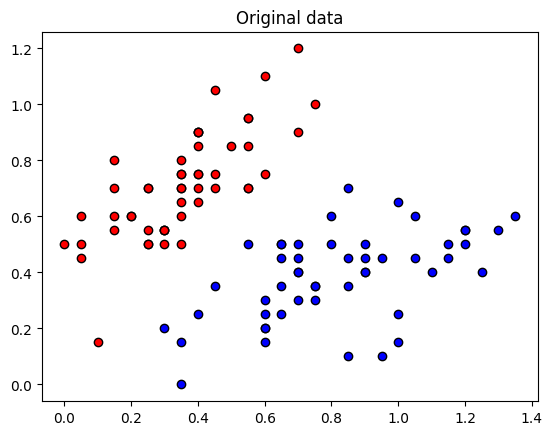

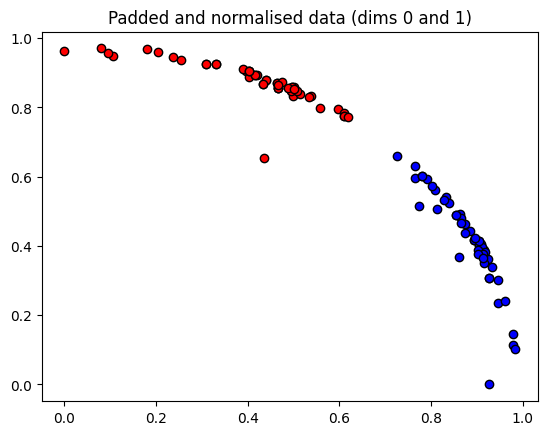

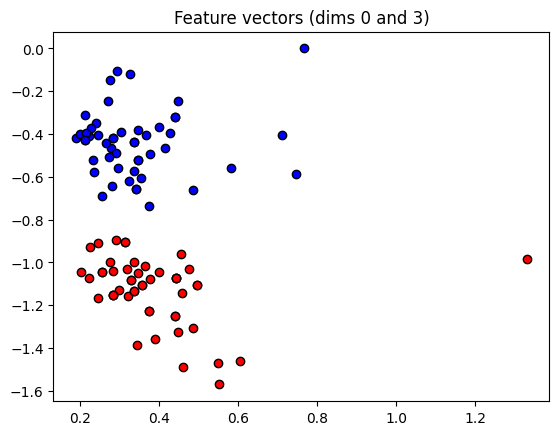

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

# Training

In [15]:
np.random.seed(0)# Reproducible Results
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]
num_qubits = 2
num_layers = 7

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [16]:
opt = AdamOptimizer(0.01)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(60):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.0380391 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 0.9411810 | Acc train: 0.6133333 | Acc validation: 0.7200000
Iter:     6 | Cost: 0.8671026 | Acc train: 0.8133333 | Acc validation: 0.8000000
Iter:     8 | Cost: 0.7887607 | Acc train: 0.8800000 | Acc validation: 0.8800000
Iter:    10 | Cost: 0.7052309 | Acc train: 0.9733333 | Acc validation: 1.0000000
Iter:    12 | Cost: 0.6303518 | Acc train: 0.9866667 | Acc validation: 0.9600000
Iter:    14 | Cost: 0.5634345 | Acc train: 0.9733333 | Acc validation: 0.8800000
Iter:    16 | Cost: 0.4904051 | Acc train: 0.9866667 | Acc validation: 0.9600000
Iter:    18 | Cost: 0.4179428 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    20 | Cost: 0.3559829 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    22 | Cost: 0.3141256 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    24 | Cost: 0.2863580 | Acc train: 1.0000000 | Acc validation: 1.0000000
Iter:    26 | Cost: 0.268528

As we can see using Hadamard at qubit 0, has significantly sped up the convergence.

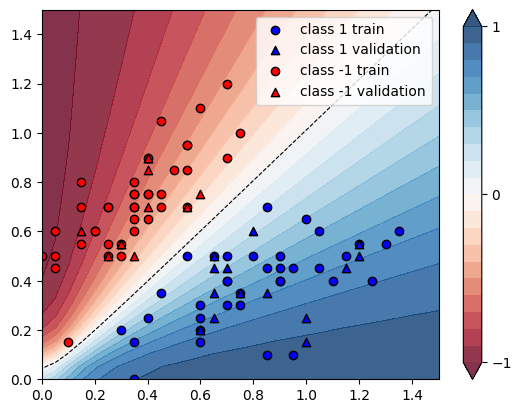

In [17]:
plt.figure()
cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()